In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets


@torch.no_grad()
def test(test_loader, model):
    model.eval()
    mse = []
    for data in test_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

In [6]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            'aggregators': ['mean', 'min', 'max', 'sum','std'],
            'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [7]:
dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)

In [8]:
# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
deg = get_deg(train_dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def Test_performance(alpha=1.0):
    
    model = ACANet_PNA(**pub_args, deg=deg).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)
        
        train_rmse = test(train_loader, model)
        val_rmse = test(val_loader, model)
        test_rmse = test(test_loader, model)
        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

# With AC-Awareness ($\alpha = 1$)

In [10]:
df1 = Test_performance(alpha=1.0)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 10.9083 tsm_loss: 4.2868 reg_loss: 6.6214 n_pos_triplets: 208746;  Val: 6.7066 Test: 6.7646
Epoch: 002, Loss: 8.0805 tsm_loss: 1.8659 reg_loss: 6.2146 n_pos_triplets: 205206;  Val: 6.7056 Test: 6.7637
Epoch: 003, Loss: 7.1247 tsm_loss: 1.4568 reg_loss: 5.6680 n_pos_triplets: 200490;  Val: 6.7019 Test: 6.7599
Epoch: 004, Loss: 6.1900 tsm_loss: 1.2640 reg_loss: 4.9259 n_pos_triplets: 187635;  Val: 6.6759 Test: 6.7340
Epoch: 005, Loss: 5.1392 tsm_loss: 1.1898 reg_loss: 3.9495 n_pos_triplets: 185443;  Val: 6.5187 Test: 6.5759
Epoch: 006, Loss: 3.7561 tsm_loss: 1.1957 reg_loss: 2.5605 n_pos_triplets: 183824;  Val: 6.0550 Test: 6.1071
Epoch: 007, Loss: 2.2476 tsm_loss: 1.2529 reg_loss: 0.9947 n_pos_triplets: 164252;  Val: 5.0557 Test: 5.0986
Epoch: 008, Loss: 2.1010 tsm_loss: 1.2467 reg_loss: 0.8544 n_pos_triplets: 156731;  Val: 3.6130 Test: 3.6405
Epoch: 009, Loss: 1.8065 tsm_loss: 1.1077 reg_loss: 0.6989 n_pos_triplets: 169134;  Val: 2.3637 Test: 2.3772
Epoch: 010, Loss: 

# Without AC-Awareness ($\alpha = 0$)

In [11]:
df2 = Test_performance(alpha=0.0)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 6.1661 tsm_loss: 10.6754 reg_loss: 6.1661 n_pos_triplets: 206059;  Val: 6.7115 Test: 6.7695
Epoch: 002, Loss: 5.1616 tsm_loss: 16.1756 reg_loss: 5.1616 n_pos_triplets: 203822;  Val: 6.7077 Test: 6.7658
Epoch: 003, Loss: 4.0051 tsm_loss: 16.8122 reg_loss: 4.0051 n_pos_triplets: 202345;  Val: 6.7019 Test: 6.7600
Epoch: 004, Loss: 2.5396 tsm_loss: 15.3341 reg_loss: 2.5396 n_pos_triplets: 199913;  Val: 6.6942 Test: 6.7523
Epoch: 005, Loss: 1.0657 tsm_loss: 13.1684 reg_loss: 1.0657 n_pos_triplets: 195396;  Val: 6.6755 Test: 6.7329
Epoch: 006, Loss: 0.7527 tsm_loss: 9.9990 reg_loss: 0.7527 n_pos_triplets: 186886;  Val: 5.9368 Test: 5.9810
Epoch: 007, Loss: 0.6790 tsm_loss: 8.2298 reg_loss: 0.6790 n_pos_triplets: 181315;  Val: 4.6801 Test: 4.7225
Epoch: 008, Loss: 0.6684 tsm_loss: 7.3231 reg_loss: 0.6684 n_pos_triplets: 176988;  Val: 3.4051 Test: 3.4315
Epoch: 009, Loss: 0.6120 tsm_loss: 6.5138 reg_loss: 0.6120 n_pos_triplets: 173442;  Val: 2.6734 Test: 2.6894
Epoch: 010, Lo

In [28]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

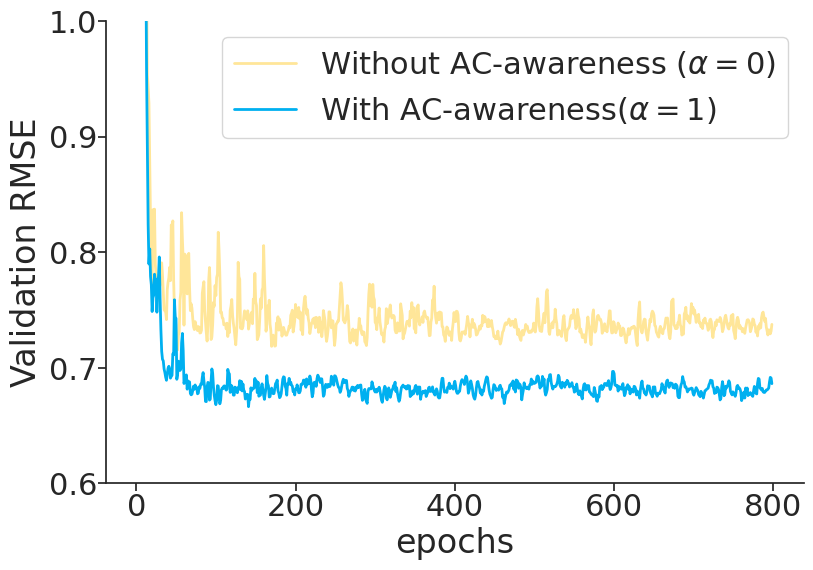

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']

n1 = r'With AC-awareness($\alpha=1$)'
n2 = r'Without AC-awareness ($\alpha = 0 $)'

dfp = df2.val_rmse.to_frame(name = n2).join(df1.val_rmse.to_frame(name = n1)).rolling(3).mean()

dfp.plot(lw = 2, ax=ax,color = colors )

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)


ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 

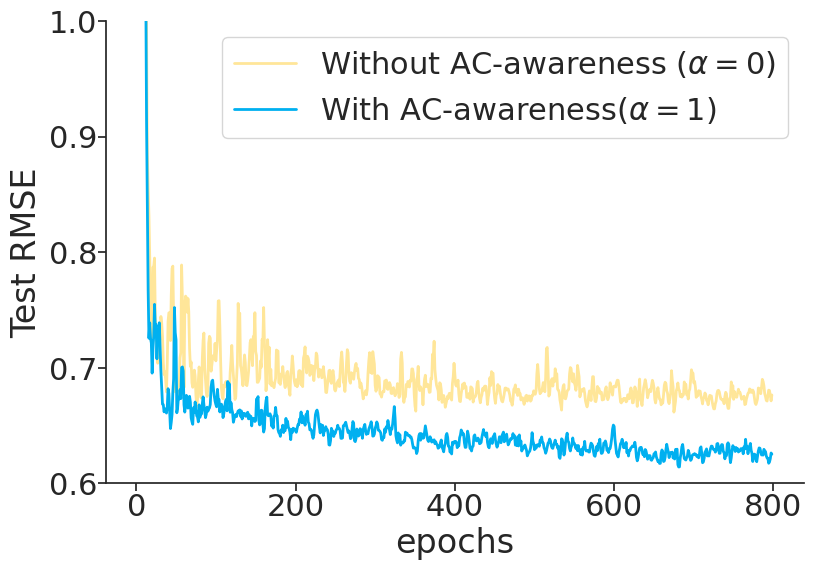

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))

dfp = df2.test_rmse.to_frame(name = n2).join(df1.test_rmse.to_frame(name =n1)).rolling(3).mean()
dfp.plot(lw = 2, ax=ax,color = colors )

ax.set_ylim(0.6, 1.0)
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 

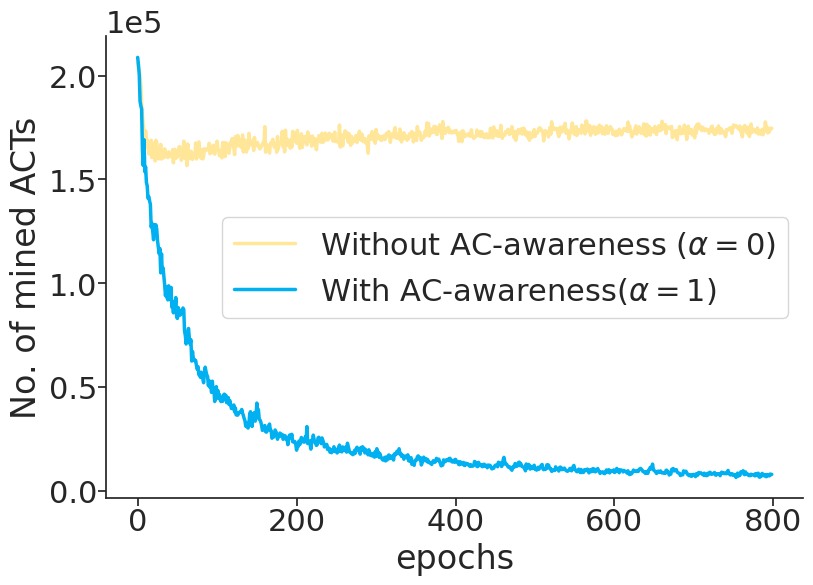

In [26]:
fig, ax = plt.subplots(figsize=(9, 6))
dfp = df2.n_pos_triplets.to_frame(name = n2).join(df1.n_pos_triplets.to_frame(name = n1)).rolling(1).mean()
dfp.plot(lw = 2.5, ax=ax,color = colors )

ax.spines[['right', 'top']].set_visible(False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('No. of mined ACTs')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 

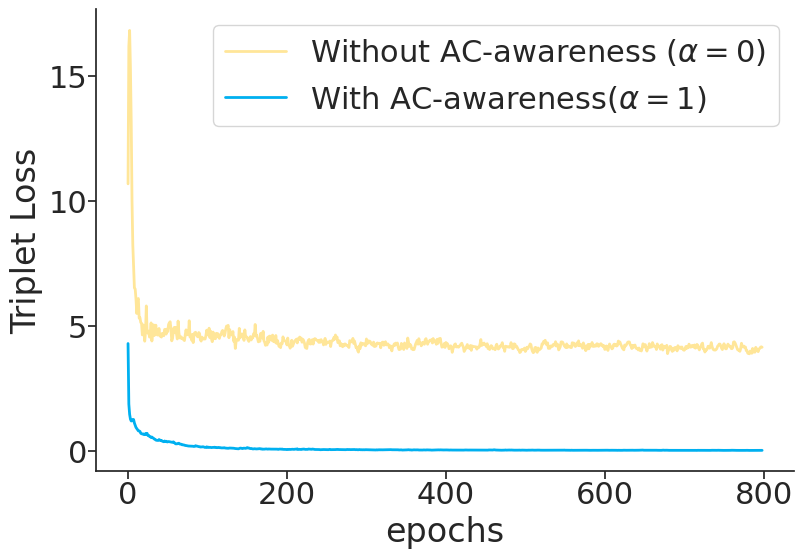

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
dfp = df2.train_triplet_loss.to_frame(name = n2).join(df1.train_triplet_loss.to_frame(name =n1))
dfp.plot(lw = 2, ax=ax,color = colors )
ax.spines[['right', 'top']].set_visible(False)

ax.set_ylabel('Triplet Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 

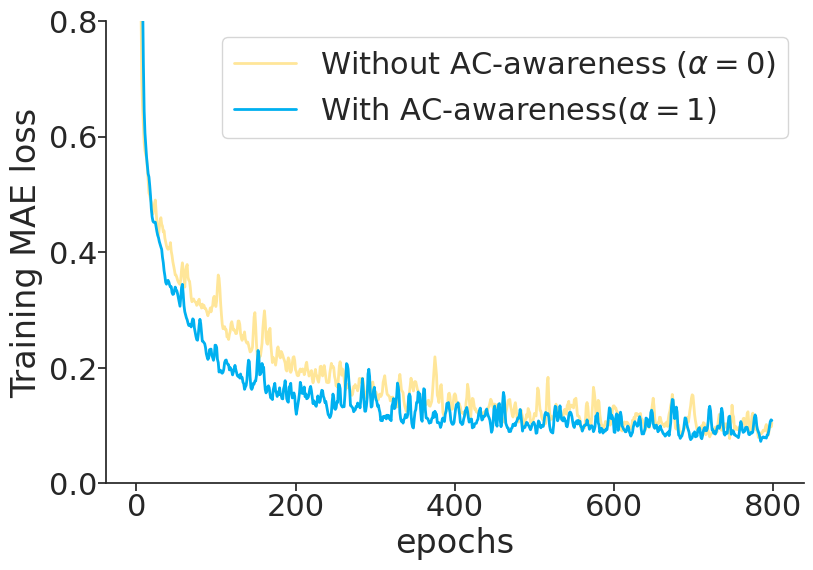

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))
dfp = df2.train_mae_loss.to_frame(name = n2).join(df1.train_mae_loss.to_frame(name = n1)).rolling(3).mean()
ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)

dfp.plot(lw = 2, ax=ax,color = colors )
ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 